# Sembradora 3000

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [15]:
# Model design
import agentpy as ap
import random
import numpy as np
from collections import namedtuple, deque
from queue import PriorityQueue
from itertools import count
import math

# Visualization
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML

# Guardar
import pickle

## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Grid

In [16]:
"""
1 is tractor
2 is obstacle
3 is target
4 is seeds
"""


def is_connected(grid, free_positions):
    """ Check if all free cells are connected using BFS """
    n = grid.shape[0]
    visited = set()
    queue = deque([free_positions.pop()])
    visited.add(queue[0])

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    connected_count = 1
    free_count = len(free_positions)

    while queue:
        x, y = queue.popleft()
        for dx, dy in directions:
            new_x, new_y = x + dx, y + dy
            if 0 <= new_x < n and 0 <= new_y < n and (new_x, new_y) in free_positions and (new_x, new_y) not in visited:
                queue.append((new_x, new_y))
                visited.add((new_x, new_y))
                connected_count += 1
        
                
    return connected_count > free_count

def generate_grid(model, n, obstacles_count):
    grid = ap.Grid(model, (n, n), track_empty=True)  # Create an agentpy Grid object
    grid.add_field("occupied", 0)  # Add a field to store obstacle information

    # Generate obstacle positions
    obstacle_positions = set()
    while len(obstacle_positions) < obstacles_count:
        x, y = random.randint(0, n-1), random.randint(0, n-1)
        if (x, y) not in obstacle_positions and (x,y) not in model.p.seedsPositions:
            obstacle_positions.add((x, y))

    # Mark grid cells as obstacles
    for pos in obstacle_positions:
        grid["occupied"][pos] = 1

    # Identify free positions
    free_positions = set()
    for pos in grid.all:
        if grid["occupied"][pos] != 1:
            free_positions.add(pos)

    # Check if the free cells are connected
    final_obstacles = set()
    while not is_connected(grid, free_positions):
        final_obstacles.clear()
        grid = ap.Grid(model, (n, n), track_empty=True)
        grid.add_field("occupied", 0)
        obstacle_positions = set()
        while len(obstacle_positions) < obstacles_count:
            x, y = random.randint(0, n-1), random.randint(0, n-1)
            if (x, y) not in obstacle_positions and (x,y) not in model.p.seedsPositions:
                obstacle_positions.add((x, y))
        
        free_positions = set()
        for pos in grid.all:
            if grid["occupied"][pos] == 0:
                free_positions.add(pos)
        final_obstacles = obstacle_positions

    for pos in obstacle_positions:
        grid["occupied"][pos] = 1
        model.np_grid[pos] = 3
    #add an agent to each obstacle position with type 2
    #Make an agentlist ap.agentlist
    #Add the agent to the grid
    #Add the agent to the agentlist
    agentlist = ap.AgentList(model, len(obstacle_positions))
    agentlist.type = 2
        
    grid.add_agents(agentlist, obstacle_positions)
    


    model.grid = grid

## Agente

In [17]:
class CollectingTractor(ap.Agent):
    def setup(self, type=1, pos=(0, 0)):
        self.collected = 0
        self.targetIndex = 1
        self.path = []
        self.destroyed = False
        self.condition = True
        self.seeds = 0
        self.type = type
        
        # Machine Learning
        self.start = pos
        self.q_table = np.zeros((self.p.grid_size, self.p.grid_size, 6))  # 6 acciones posibles
        self.learning_rate = 0.1
        self.discount_factor = 0.9
        self.epsilon = 0.1  
        self.pos = pos  # Posición inicial
        
    # Función para moverse arrriba
    def move_up(self):
        x, y = self.pos
        if y < self.p.grid_size - 1:
            self.model.grid.move_to(self, (x, y + 1))
            self.pos = (x, y + 1)
            accionado = True
            return self.pos, accionado
        else:
            accionado = False
            return self.pos, accionado
        
    # Función para moverse abajo
    def move_down(self):
        x, y = self.pos
        if y > 0:
            self.model.grid.move_to(self, (x, y - 1))
            self.pos = (x, y - 1)
            accionado = True
            return self.pos, accionado
        else:
            accionado = False
            return self.pos, accionado
        
    # Función para moverse a la izquierda
    def move_left(self):
        x, y = self.pos
        if x > 0:
            self.model.grid.move_to(self, (x - 1, y))
            self.pos = (x - 1, y)
            accionado = True
            return self.pos, accionado 
        else:
            accionado = False
            return self.pos, accionado
        
    # Función para moverse a la derecha
    def move_right(self):
        x, y = self.pos
        if x < self.p.grid_size - 1:
            self.model.grid.move_to(self, (x + 1, y))
            self.pos = (x + 1, y)
            accionado = True
            return self.pos, accionado
        else:
            accionado = False
            return self.pos, accionado
    
    # función para dejar una semilla
    def drop(self):
        x, y = self.pos
        if self.seeds > 0 and self.pos == self.targets[self.targetIndex]:
            self.targetIndex += 1
            self.seeds -= 1
            if (self.targetIndex >= len(self.targets)):
                self.destroyed = True
            accionado = True
            return self.pos, accionado
        else:
            accionado = False
            return self.pos, accionado
            
    # función para recoger una semillas
    def collect(self):
        x, y = self.pos
        if self.model.np_grid[self.pos] == 4 and self.seeds == 0: # If semillas == 0, agarra semilas
            self.seeds = self.capacity
            accionado = 1
            return self.pos, accionado
        elif self.model.np_grid[self.pos] == 4 and self.seeds < self.capacity: # If semillas < capacidad maxima, agarra semillas
            self.seeds = self.capacity
            accionado = 2
            return self.pos, accionado
        else: # Si semillas == capacidad maxima, no agarra semillas
            accionado = 3
            return self.pos, accionado
    
    
    def get_reward(self, action, agents, accionado):
        if action == 0:  # Arriba
            if accionado == True:
                reward = -5  # Penalización por step
            else:
                reward = -15  # Penalización por intentar salir del límite
        elif action == 1:  # Abajo
            if accionado == True:
                reward = -5
            else:
                reward = -15
        elif action == 2:  # Izquierda
            if accionado == True:
                reward = -5
            else:
                reward = -15
        elif action == 3:  # Derecha
            if accionado == True:
                reward = -5
            else:
                reward = -15
        elif action == 4:  # Dejar
            if accionado == True:
                reward = 10  # Recompensa positiva por dejar semillas
            else:
                reward = -15  # Recompensa negativa por intentar dejar sin semillas
        elif action == 5:  # Recoger
            if accionado == 1:
                reward = -5
            elif accionado == 2:
                reward = -10
            else:
                reward = -15
        else:
            # Penalización pequeña por cada movimiento para incentivar la eficiencia
            reward = -10

        # Verificación de colisiones con otros agentes
        for agent in agents:
            if agent != self and agent.pos == self.pos:
                reward -= 50  # Penalización por colisión con otro agente
                break
        
        # Verificación de colisiones con obstáculos
        if self.model.np_grid[self.pos] == 2:
            reward -= 100

        return reward

    def q_learning_update(self, state, action, reward, next_state):
        # Desempaqueta las coordenadas de estado y next_state
        x, y = state
        next_x, next_y = next_state

        # Accede al valor Q actual
        current_q = self.q_table[x, y, action]

        # Encuentra el valor máximo de Q para el siguiente estado
        max_next_q = np.max(self.q_table[next_x, next_y])

        # Calcula el nuevo valor Q
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)

        # Actualiza la Q-table
        self.q_table[x, y, action] = new_q


    def acciones(self, action):
        if action == 0:  # Arriba
            return self.move_up()
        elif action == 1:  # Abajo
            return self.move_down()
        elif action == 2:  # Izquierda
            return self.move_left()
        elif action == 3:  # Derecha
            return self.move_right()
        elif action == 4:  # Dejar
            return self.drop()
        elif action == 5:  # Recoger
            return self.collect()


    def step(self, agents):
        if (self.destroyed):
            return

        state = self.pos  # Estado actual (x, y)
        x, y = state
        
        # Selección de acción usando epsilon-greedy
        if np.random.rand() < self.epsilon:
            action = np.random.choice([0, 1, 2, 3, 4, 5])  # Explorar
        else:
            action = np.argmax(self.q_table[x, y])  # Explotar
            
        # Reduce epsilon (Exploración) con el tiempo
        self.epsilon = max(0.1, self.epsilon * 0.995)  # Se asegura que epsilon no baje de 0.1

        # Ejecuta la acción y obtiene el nuevo estado y el resultado
        next_state, accionado = self.acciones(action)
        
        # Calcula la recompensa basada en la acción y el estado
        reward = self.get_reward(action, agents, accionado)

        # Actualiza la tabla Q
        self.q_learning_update(state, action, reward, next_state)

        # Actualiza la posición del agente
        self.pos = next_state


#### Ambiente

In [18]:
class TractorModel(ap.Model):
    def setup(self):
        # Inicializa el ambiente y guarda las coordenadas generadas
        self.initialized = False
        self.reset()

    def reset(self):
        # Solo genera nuevas coordenadas la primera vez
        if not self.initialized:
            self.Collected = 0
            self.np_grid = np.zeros((self.p.grid_size, self.p.grid_size))
            
            # Generar y guardar las posiciones de los obstáculos
            generate_grid(self, self.p.grid_size, self.p.obstacles_count)
            self.obstacle_positions = np.copy(self.grid["occupied"])

            # Re-crea la lista de agentes y sus propiedades
            self.agents = ap.AgentList(self, self.p.number_of_tractors, CollectingTractor)
            self.agents.capacity = self.p.capacity
            self.agents.seeds = self.p.starting_seeds
            self.agents.targetIndex = 1
            self.agents.destroyed = False

            # Asigna posiciones y objetivos a los tractores
            self.coordsUsed = set()
            self.targets_by_tractor = []
            for tractor in self.agents:
                targets = []
                for i in range(self.p.number_of_targets + 1):
                    x, y = random.randint(0, self.p.grid_size-1), random.randint(0, self.p.grid_size-1)
                    while self.grid["occupied"][(x, y)] == 1 or (x, y) in self.coordsUsed:
                        x, y = random.randint(0, self.p.grid_size-1), random.randint(0, self.p.grid_size-1)
                    targets.append((x, y))
                    self.coordsUsed.add((x, y))
                self.targets_by_tractor.append(targets)
                tractor.targets = targets
                tractor.pos = targets[0]
                self.np_grid[tractor.pos] = 1

            self.grid.add_agents(self.agents, [tractor.pos for tractor in self.agents])
            self.initialized = True  # Marcar como inicializado
        else:
            # Restaurar las posiciones de obstáculos y objetivos previas
            self.grid["occupied"] = np.copy(self.obstacle_positions)
            self.np_grid = np.zeros((self.p.grid_size, self.p.grid_size))
            for tractor, targets in zip(self.agents, self.targets_by_tractor):
                tractor.targets = targets
                tractor.pos = targets[0]
                self.np_grid[tractor.pos] = 1

            self.grid.add_agents(self.agents, [tractor.pos for tractor in self.agents])

    def update(self):
        # Actualiza la cantidad de objetivos recolectados
        self.record('Collected', sum([tractor.collected for tractor in self.agents]))

    def step(self):
        # Ejecuta un paso para todos los agentes
        self.agents.step(self.agents)
        # Marca las posiciones de las semillas en la grilla
        for seed in self.p.seedsPositions:
            self.np_grid[seed] = 4

    def end(self):
        # Reporta el total de objetivos al final de la simulación
        self.report('Total targets', self.p.number_of_targets * self.p.number_of_tractors)


## Parameters

In [19]:


tractorParameters = {
    'grid_size': 10,
    'obstacles_count': 10,
    'number_of_tractors': 2,
    'number_of_targets': 20,
    'steps': 100,
    'seedsPositions': [(0, 0)],
    'capacity': 2,
    'starting_seeds': 2,
}

Animation

In [20]:
"""
0 is empty
1 is tractor
2 is obstacle
3 is target
4 is seeds
"""

# Load images
tractor_img = mpimg.imread('tractor.png')
obstacle_img = mpimg.imread('obstacle.png')
target_img = mpimg.imread('target.png')
seeds_img = mpimg.imread('seeds.png')

def animation_plot(model, ax):
    # Clear the axis to avoid over-plotting
    ax.clear()

    # Plot the grid using images
    for (x, y), value in np.ndenumerate(model.np_grid):
        if value == 1:  # Tractor
            ax.imshow(tractor_img, extent=[y, y+1, x, x+1], aspect='auto')
        elif value == 3:  # Obstacle
            ax.imshow(obstacle_img, extent=[y, y+1, x, x+1], aspect='auto')
        elif value == 2:  # Target
            ax.imshow(target_img, extent=[y, y+1, x, x+1], aspect='auto')
        elif value == 4:  # Seeds
            ax.imshow(seeds_img, extent=[y, y+1, x, x+1], aspect='auto')

    # Add text for each tractor displaying the number of seeds it has
    for agent in model.agents:
        if agent.destroyed:
            continue
        ax.text(agent.pos[1] + 0.5, agent.pos[0] + 0.5, str(agent.seeds),
                color='black', fontsize=12, ha='center', va='center', weight='bold')

    # Fix axis limits based on the grid dimensions
    ax.set_xlim([0, model.np_grid.shape[1]])
    ax.set_ylim([0, model.np_grid.shape[0]])

    # Set aspect ratio to 'equal' to prevent image stretching
    ax.set_aspect('equal')

    # Set the title for the plot
    ax.set_title(f"Tractor model \n Time-step: {model.t}, Collected: {model.Collected}")

## Machine Learning

C:\Users\andy5\AppData\Local\Temp\ipykernel_17448\127587482.py:35: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grid.add_field("occupied", 0)  # Add a field to store obstacle information


Episode 1: Total Reward = -537680, Epsilon = 0.1
Episode 2: Total Reward = 0, Epsilon = 0.1


MovieWriter ffmpeg unavailable; using Pillow instead.


Episode 3: Total Reward = -461430, Epsilon = 0.1


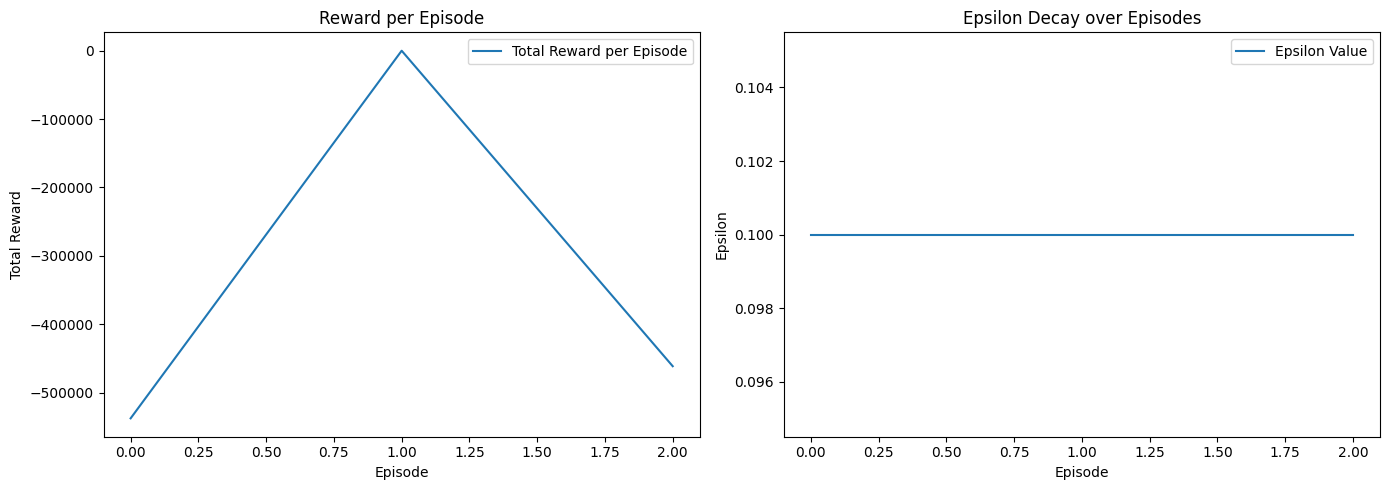

In [22]:
# Configuración de parámetros
num_episodes = 3  # Número de episodios para entrenar y evaluar
rewards_per_episode = []
epsilon_values = []

# Crear una única instancia del modelo
model = TractorModel(tractorParameters)
model.setup()  # Configurar el modelo

# Entrenamiento del agente
for episode in range(num_episodes):
    model.reset()  # Resetear el ambiente al inicio de cada episodio
    
    total_reward = 0

    # Para la animación del último episodio
    if episode == num_episodes - 1:
        fig, ax = plt.subplots()
        animation = ap.animate(model, fig, ax, animation_plot)

    while True:
        model.step()  # Ejecutar un paso del modelo
        
        # Acumular las recompensas obtenidas por todos los agentes
        end = True;
        for agent in model.agents:
            if (agent.destroyed):
                continue
            end = False
            x, y = agent.pos
            action = np.argmax(agent.q_table[x, y])  # Obtener la acción elegida
            accionado = agent.acciones(action)[1]
            reward = agent.get_reward(action, model.agents, accionado)  # Obtener recompensa
            total_reward += reward  # Acumular la recompensa obtenida
        
        if end:  # Verificar si se cumple la condición de finalización del episodio
            break

    # Guardar la recompensa total del episodio y el valor de epsilon
    rewards_per_episode.append(total_reward)
    epsilon_values.append(model.agents[0].epsilon)  # Se asume que todos los agentes tienen el mismo epsilon
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward}, Epsilon = {model.agents[0].epsilon}")

# Guardar la animación del último episodio como un GIF
animation.save('simulacionTractores.gif')

# Guardar la Q-table al final del entrenamiento
q_table = model.agents[0].q_table  # Asumiendo que todos los agentes comparten la misma Q-table
with open('q_table.pkl', 'wb') as f:
    pickle.dump(q_table, f)

# Graficar el rendimiento
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards_per_episode, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epsilon_values, label='Epsilon Value')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay over Episodes')
plt.legend()

plt.tight_layout()
plt.show()

Final execution

In [ ]:
'''
# Asignar la Q-table cargada a los agentes
model = TractorModel(tractorParameters)
model.setup()

for agent in model.agents:
    agent.q_table = q_table  # Asignar la Q-table cargada a cada agente

# Ahora puedes continuar entrenando o simular el comportamiento
model.reset()  # Resetear el ambiente si es necesario
model.step()  # Ejecutar pasos del modelo utilizando la Q-table cargada
'''